In [1]:
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pyoso import Client
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from matplotlib.colors import LogNorm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

load_dotenv()
OSO_API_KEY = os.environ['OSO_API_KEY']
client = Client(api_key=OSO_API_KEY)
stringify = lambda arr: "'" + "','".join(arr) + "'"

In [41]:
# Analysis parameters
MOST_RECENT_MEASUREMENT_PERIOD = 5

GITHUB_START_DATE = "2020-01-01"
GITHUB_END_DATE   = "2025-06-30"

ONCHAIN_START_DATE = "2025-01-01"
ONCHAIN_END_DATE   = "2025-06-30"

METRIC_START_DATE = "2025-01-01"
METRIC_END_DATE   = "2025-06-01"

RETROFUNDING_REPO_URL = "https://raw.githubusercontent.com/ethereum-optimism/Retro-Funding/refs/heads/main/results/S7"

# Queries

## Projects, Rewards, Labels

In [11]:
df_devtool_projects = client.to_pandas("""
   SELECT DISTINCT
     p.project_id AS oso_id,
     p.project_name AS atlas_id,
     p.display_name AS project_name
   FROM projects_v1 AS p
   JOIN projects_by_collection_v1 AS pbc ON p.project_id = pbc.project_id
   JOIN collections_v1 AS c ON pbc.collection_id = c.collection_id
   WHERE c.display_name = 'Retro Funding S7: Developer Tooling'
""")

df_devtool_projects

,oso_id,atlas_id,project_name
0,vvd53Q/49SJ6mNQXcn67dlUHSbExIKjGDsZbloH8R6g=,0x5f9f1b45eb4a49e8c2482288e02c8fc1e0e60ad3e88f...,Diamondscaffold: Simplifying EIP-2535 Diamond ...
1,Gs3aazAbSMODmvjViBNNN3SIoyQtGQL9p1kipzQDPvg=,0x8589657542ff4b7c5071dfdeff18a041642a72344ede...,Chimera
2,5/9fRbVoDF7pHwBdiMbNUbKhidEt/12Ojt9f8cWoZnQ=,0x08df6e20a3cfabbaf8f34d4f4d048fe7da40447c24be...,Velodrome Finance
3,uGbSlae4LNwwsCMEQRkgXeWpslj9Fb2t2pHzS6aj82A=,0xbb067b01988521110c91737f058e7301f608be231d85...,Synpress
4,35ZzBNWt/ueafBC7PqicOEqDTuuNWr0TTafOTMa1J60=,0x14eab8b10f729239d63df6c0cb85f666c3eb1f2dd440...,Ethernal
...,...,...,...
237,D/EXUXnX8dbOCU6qXNGAgNxhLOdodwJNNjMPeLUHSu4=,0xcc8d03e014e121d10602eeff729b755d5dc6a317df0d...,Solidity
238,SUaETe9RSmxA6e5SBseHYYZJylEoxPRSMrdjhHoh55I=,0x92f33d0611c514cafbf54780ec7925a6080a37a19268...,PinSave
239,B7Gzx+ZyWdQ5tfzIxWc6A9uWVJ0ZPNOb0YnbtcjXS0w=,0xbaccff0188ef78c1bab0c9798b0faceee552de1dee4f...,Verifereum
240,Do7XmLDYP7t4xDWAldvqGF8KevofT/SUPeKGpg089ag=,0x60565a1ff56360c729ec5e33b27040acd6d495e35e32...,New Project


In [114]:
def get_round_results(m_id, category):
    url = f"{RETROFUNDING_REPO_URL}/M{m_id}/outputs/{category}__results.json"
    result = pd.read_json(url)
    result = result[['op_atlas_id', 'op_reward']]
    result.columns = ['atlas_id', 'op_reward']
    result['category'] = category
    result['measurement_period'] = m_id
    return result

def get_all_round_results(category):
    dfs = []
    for m_id in range(1, MOST_RECENT_MEASUREMENT_PERIOD + 1):
        dfs.append(get_round_results(m_id, category))
    return pd.concat(dfs, axis=0, ignore_index=True)

df_devtool_rewards = get_all_round_results("devtooling").groupby('atlas_id', as_index=False)['op_reward'].sum()
df_devtool_rewards['is_funded'] = df_devtool_rewards['op_reward'] > 0
df_devtool_rewards

,atlas_id,op_reward,is_funded
0,0x0008577196fa6ec286440b418e2f6305fc10e62ce759...,35545.50,True
1,0x07222a857f4522026d91faec337e3cb8cf6ec5f7afb8...,1418.48,True
2,0x076a2b1418a515ff8c5bb11beed5630cc6fe7f65fd8d...,0.00,False
3,0x08df6e20a3cfabbaf8f34d4f4d048fe7da40447c24be...,3822.80,True
4,0x09b95c7697625da4915338750c5f78446817a3634cb3...,9630.26,True
...,...,...,...
240,0xfb3ac4e5f7665c6560e461c1b77ed896d355635947a6...,0.00,False
241,0xfbc74fb5d15b7b2554277371a41ee6ff1bf392377bce...,4235.73,True
242,0xfbecd6308658b3d40a5249d4b249d10537165f57ea52...,0.00,False
243,0xfc54b4a9c537be25238cba3f05100b733aeee83a3eb3...,19145.02,True


In [95]:
def get_devtool_labels(m_id):
    url = f"{RETROFUNDING_REPO_URL}/M{m_id}/data/devtooling__utility_labels.csv"
    df_devtool_labels = pd.read_csv(url)
    df_devtool_labels.columns = ['atlas_id', 'project_name', 'category_label']
    return df_devtool_labels

df_devtool_labels = get_devtool_labels(MOST_RECENT_MEASUREMENT_PERIOD)
df_devtool_labels

,atlas_id,project_name,category_label
0,0x120cdd8e43ae1efbafdf02eda876e1952c05a52870c8...,Passport XYZ | Gitcoin Passport,Application-Specific & Niche Tools
1,0x93decae913f62c0a86519d0b0798e4a10c46c541bfc1...,LlamaPay,Application-Specific & Niche Tools
2,0x08df6e20a3cfabbaf8f34d4f4d048fe7da40447c24be...,Velodrome Finance,Application-Specific & Niche Tools
3,0x8967594d2978692a35fea137ba640bb42f11cad907ca...,Hats Protocol,Application-Specific & Niche Tools
4,0xcc9301a401320c626839db9c4415f28a6e1f2fb3abdf...,DexKit,Application-Specific & Niche Tools
...,...,...,...
237,0xd6622026215d1489594ab9bb76b1e652eae1fd42d180...,Jolt Finance,Application-Specific & Niche Tools
238,0xeef42373d10554d65aba9e6deb8333a4eddebba829e0...,ERCx: Token Test Library,Deployment & Lifecycle Management
239,0xf152ccbfb3aa63c2ddcc070dc6d4462368eb25b69c3c...,Derive Exchange SDK and Vault Executors,Application-Specific & Niche Tools
240,0xf9c5d092fac6ad924253d685cc7ba21d4e519813e673...,NFTScan,Application-Specific & Niche Tools


## Repos & Developer Metrics

In [16]:
df_devtool_repos = client.to_pandas(f"""
SELECT DISTINCT
  abp.project_name AS atlas_id,
  g.artifact_id,
  g.artifact_url
FROM int_artifacts__github AS g
JOIN artifacts_by_project_v1 AS abp
  ON g.artifact_source_id = abp.artifact_source_id
WHERE abp.project_id IN ({stringify(df_devtool_projects['oso_id'])})
""")

df_devtool_repos

,atlas_id,artifact_id,artifact_url
0,0xa88844cea135382e3484e39c3172033437121b35ca0b...,iNY0yLLC3YsQyRplp/j6MCU9sfKDqa1ZFiSKklmDWDc=,https://github.com/ethereum-attestation-servic...
1,0x7a4bb37bc7997b8e9b34775164682ff1f441b716cd23...,v3iwkwW5ieuYL4HkKQwSnWSwjc90MfFXHj1uzrPr3Jc=,https://github.com/zkcodex/zkcodex
2,0x08df6e20a3cfabbaf8f34d4f4d048fe7da40447c24be...,JQM1UJ6eB1stjLEuvIlgenDhAk3vWxuMtGB3r/EFiVE=,https://github.com/velodrome-finance/sugar-sdk
3,0x4e175118c15129e6cc791203de92b23f11fef35ba4bc...,JJag1bu+ppgGdHuhxaAJ02bpWrhoZcAQwe0xXD3Dt+8=,https://github.com/heypran/zk-block
4,0x5cfdb8c453a7eede1946071e9d7417d01cc2116f5756...,kWarrkW0O5Wz2RHvb5N9MWjxrgdOv0+NLYIgv+bcMs0=,https://github.com/aspiringsecurity/emttr
...,...,...,...
675,0xe6eb4d61eff4e2dc2d8dba01ac1b84c1683bdb1e8d67...,lLsdfrEs9S5r5Dg3sfxcNjQhKQhtB2dyLwExRME5KG8=,https://github.com/raiden1411/zabi
676,0x939241afa4c4b9e1dda6b8250baa8f04fa8b0debce73...,Kiizi127ss6Z79antU3mSbG+x+dHOLxvc6SDay3NTHA=,https://github.com/openzeppelin/openzeppelin-c...
677,0xf00e745fe6d96359adc3dc45d6d811bf1140549ad830...,0rrwll1mVl8/sviRP21gErMwelSQqlx+fbbaJlNqpB0=,https://github.com/apoorvlathey/eip-tools
678,0x541b7b08401d799b87f583c102a6c94cee7105f1b29d...,/GXnHYnxGSeSCoGyLnX4PdRoDwYDJwLUF6bPD6o4SZo=,https://github.com/ethereum/rust-vyper


In [26]:
df_devtool_metrics = client.to_pandas(f"""
WITH metrics AS (
  SELECT metric_id, metric_name
  FROM metrics_v0
  WHERE metric_name IN (
    'GITHUB_full_time_developers_monthly',
    'GITHUB_part_time_developers_monthly',
    'GITHUB_active_developers_monthly'
  )
)

SELECT
  tm.sample_date,
  tm.artifact_id,
  m.metric_name AS metric,
  SUM(tm.amount) AS amount
FROM timeseries_metrics_by_artifact_v0 AS tm
JOIN metrics AS m ON tm.metric_id = m.metric_id
WHERE 
  tm.sample_date BETWEEN DATE('{GITHUB_START_DATE}') AND DATE('{GITHUB_END_DATE}')
  AND tm.artifact_id IN ({stringify(df_devtooling_repos['artifact_id'].unique())})
GROUP BY 1,2,3
""")

df_devtool_metrics

## Downstream Gas & Devs

In [33]:
df_dependency_graph = client.to_pandas(f"""
SELECT DISTINCT
  cd.dependency_artifact_id,
  p.project_id,
  p.project_name
FROM int_code_dependencies AS cd
JOIN int_superchain_s7_devtooling_onchain_builder_nodes AS onchain_builders
  ON cd.dependent_artifact_id = onchain_builders.repo_artifact_id
JOIN projects_v1 AS p ON onchain_builders.project_id = p.project_id
WHERE cd.dependency_artifact_id IN ({stringify(df_devtool_repos['artifact_id'])})
""")

df_dependency_graph

,dependency_artifact_id,project_id,project_name
0,Zv9i5shYSOh9Bw+maVk0uF2+fwjKE3y5wRh8Se+nTeg=,Y9rXNLJ/h4thc8N6RaRQEp6qaOyGsTOF8UV+xttzzK4=,1-inch
1,/Mk3y4o7pUi5esk3VoLvZ5X++QZxfb74v4eq2fxM3BY=,HG82ZJgWrvt0Nq2de4DtXoNFMaCv22KSY72BQs6+bNc=,extra-finance
2,Zv9i5shYSOh9Bw+maVk0uF2+fwjKE3y5wRh8Se+nTeg=,om+w927v3zYcmk77AShf/wH4sac6MkhpIWBW0H/wYkE=,hai-on-op
3,lycu1tyiKItr0LtKjzHm3dmwMjsxt4KfYpTzh9u60SQ=,3w5F55uqpaNFRoyfSg9GZYpbSTlbOlgLBVFVf9E7ta0=,uncx-network
4,Zv9i5shYSOh9Bw+maVk0uF2+fwjKE3y5wRh8Se+nTeg=,fba6SXRqy1wsgDBB/zHIZcQpBon7em6n2ntaHq5J29c=,brahma
...,...,...,...
2961,8+idxeJBXoGcJyTRsFxyHz52OHEzft0GooqnlzQCCnU=,tI9+ol8dLfp7deTjbL+mWR3TKqivSnB0UJR4QN0Nh9M=,d-hedge
2962,4uAAnTeDHahniWMNJ/Xqb9bDUoB1Bu/18kAWPxkFkgA=,OZc8hUTVvRXzEXAMJ6IqHeYqiGCecD6pH396GAijm/Y=,decent
2963,jhDdqsw1XDX8u/u+TJAKoFKCmQujye0vvm9TyDAREQ8=,kqujZQziAKlmF1hZHKciuM4kcUp+XOn5Fo/d+VZMa2E=,rainbow
2964,nnV38dje8n1wX/BmoxYFlXdd6Nt32DjYKSTcewXZHD0=,SIoNRfJjZLggEx5EQh0PpIOHxsUr1CAMkth1qolKAkk=,exactly


In [42]:
df_downstream_gas = client.to_pandas(f"""
WITH relevant_artifacts AS (
  SELECT artifact_id
  FROM artifacts_by_project_v1
  WHERE project_id IN ({stringify(df_dependency_graph['project_id'].unique())})
)

SELECT SUM(e.amount / 1e18) AS gas_fees
FROM int_events_daily__blockchain AS e
JOIN relevant_artifacts ra ON e.to_artifact_id = ra.artifact_id
WHERE
  bucket_day BETWEEN DATE('{ONCHAIN_START_DATE}') AND DATE('{ONCHAIN_END_DATE}')
  AND event_type = 'CONTRACT_INVOCATION'
""")

df_downstream_gas

,gas_fees
0,20790.712436


In [43]:
df_superchain_gas = client.to_pandas(f"""
SELECT SUM(gas_used / 1e18 * gas_price) AS total_amount
FROM stg_superchain__transactions
WHERE block_timestamp BETWEEN DATE('{ONCHAIN_START_DATE}') AND DATE('{ONCHAIN_END_DATE}')
""")

df_superchain_gas

,total_amount
0,97773.952391


In [52]:
df_downstream_devs = client.to_pandas(f"""
WITH onchain_builders AS (
  SELECT DISTINCT project_id
  FROM int_superchain_s7_devtooling_onchain_builder_nodes
  WHERE
    sample_date = DATE('{METRIC_END_DATE}')
    AND project_id IN ({stringify(df_dependency_graph['project_id'].unique())})
),
metrics AS (
  SELECT metric_id, metric_name
  FROM metrics_v0
  WHERE metric_name IN (
    'GITHUB_full_time_developers_monthly',
    'GITHUB_part_time_developers_monthly',
    'GITHUB_active_developers_monthly'
  )
)
SELECT
  tm.sample_date,
  tm.project_id,
  m.metric_name AS metric,
  SUM(tm.amount) AS amount
FROM timeseries_metrics_by_project_v0 AS tm
JOIN onchain_builders ON tm.project_id = onchain_builders.project_id
JOIN metrics AS m ON tm.metric_id = m.metric_id
WHERE sample_date BETWEEN DATE('{GITHUB_START_DATE}') AND DATE('{GITHUB_END_DATE}')
GROUP BY 1,2,3
""")

df_downstream_devs

,sample_date,project_id,metric,amount
0,2022-02-01,9f/wyYnV87C9zOzI22LcgbKAO+yQQI2fx9o3tVVjHMg=,GITHUB_part_time_developers_monthly,2
1,2022-09-01,L1FGc2AIMWcbDulPkpgzndWnljElZEAxxr+jPOdn0WQ=,GITHUB_part_time_developers_monthly,11
2,2022-09-01,6E3DyJA6elKGNzeUnrVYN/T9kutfmbzXXNbOlvSfnZM=,GITHUB_part_time_developers_monthly,3
3,2022-02-01,UwA+rfAJH1h9rWmpcFNmmXQgXGDkkQvjALJ3ejmCWRc=,GITHUB_part_time_developers_monthly,1
4,2022-02-01,QTGRjfPgumLZqvmjh/nP1wE3ZWzKnGhCY/E72h1wusw=,GITHUB_part_time_developers_monthly,7
...,...,...,...,...
12301,2024-02-01,/48A4/LZsBf1ztk3blMoY9kPQjx8knNp/EabsEszQ4Y=,GITHUB_part_time_developers_monthly,17
12302,2024-02-01,UvyC6Todt+7bSozBcCi7nGv7/MtQgyukYFuRuRz6GfQ=,GITHUB_part_time_developers_monthly,2
12303,2024-02-01,dqzR9ewlyPu0+Aje2ltI9fv6Rfg/8FCOm/oAC3Ni4Yo=,GITHUB_active_developers_monthly,2
12304,2024-02-01,ZzH9XQNZ7nWOlugpkz8GaQQEmQzx1rKxaPrvhJ+l87Y=,GITHUB_active_developers_monthly,2


metric
GITHUB_active_developers_monthly       724.166667
GITHUB_full_time_developers_monthly     88.666667
GITHUB_part_time_developers_monthly         635.5
Name: amount, dtype: Float64

## Center of Gravity

In [74]:
df_center_of_gravity = client.to_pandas(f"""
SELECT
  cd.dependency_artifact_id AS artifact_id,
  COUNT(DISTINCT CASE WHEN onchain_builders.project_id IS NOT NULL THEN cd.dependent_artifact_id END) AS superchain_dependent_repos,
  COUNT(DISTINCT cd.dependent_artifact_id) AS all_dependent_repos
FROM int_code_dependencies AS cd
LEFT JOIN int_superchain_s7_devtooling_onchain_builder_nodes AS onchain_builders
  ON cd.dependent_artifact_id = onchain_builders.repo_artifact_id
WHERE cd.dependency_artifact_id IN ({stringify(df_devtool_repos['artifact_id'])})
GROUP BY 1
""")

df_center_of_gravity

,artifact_id,superchain_dependent_repos,all_dependent_repos
0,ubIMXR4ZR33sCn0DnRidZ6nKkhO4LfBvb1+VJF3kCj8=,291,2757
1,LfWiAWM9zHcL6sspKZpGd2fwFdgpYSQoHH73pY7AXZs=,135,1832
2,eD3m98IJzrF3RYhw9bicjK6uAE9cC2E7L2rbtlzsMNg=,34,213
3,LDJ1xTsHMgFqMEw+Li1ZAOB8/0R8ZguM93ufgshlhMo=,930,8187
4,xhIi1GzmTZ/9WMQrsG8tLyDNLwQc85XsQ8j5bict3Yg=,13,83
...,...,...,...
113,qUGbR/XaVH2j0WuWhLb2qWBwfPYM95DZ3K66f8dXi64=,1,67
114,/3/zKXKH/SBfyjR/6MlVYh8anhOjH94+5wsE0tmZJKY=,0,10
115,hN0NEEEIV/VNxQ+sMmIa77wwKvxot0co1stUOv+y9qk=,0,3
116,5GKnuFsoRvQ01RbrTuYNK42AWBMwWlbrgmfLE8zcudU=,0,6


# Transformations

## Project Derived Metrics

In [115]:
df_devtool_metrics_by_project = (
    df_devtool_metrics
    .merge(df_devtool_repos, on='artifact_id')
    .groupby(['sample_date', 'atlas_id', 'metric'], as_index=False)['amount']
    .sum()
)
df_devtool_metrics_by_project['atlas_id'].nunique()

238

In [170]:
df_center_of_gravity_by_project = (
    df_center_of_gravity
    .merge(df_devtool_repos, on='artifact_id')
    .sort_values(by=['superchain_dependent_repos', 'all_dependent_repos'], ascending=False)
    .drop_duplicates(subset='atlas_id', keep='first')
)
df_center_of_gravity_by_project = df_center_of_gravity_by_project[['atlas_id', 'superchain_dependent_repos', 'all_dependent_repos']]
df_center_of_gravity_by_project['superchain_ratio'] = (
    df_center_of_gravity_by_project['superchain_dependent_repos'] 
    / df_center_of_gravity_by_project['all_dependent_repos']
)
df_center_of_gravity_by_project['is_eligible_package'] = df_center_of_gravity_by_project['superchain_dependent_repos'] >= 3
df_center_of_gravity_by_project

,atlas_id,superchain_dependent_repos,all_dependent_repos,superchain_ratio,is_eligible_package
96,0xa3d07f453f70d844196d89d79848aa2e70a0bd8b38bf...,1876,18725,0.100187,True
34,0x62d9a8a3b602c688610abfbe3965e04ca0d19c5c506f...,1292,12078,0.106971,True
68,0x4c9626843c4e3f3c96d80b0ec6b1d10b7682fc9b6d67...,1035,10261,0.100867,True
3,0xcc8d03e014e121d10602eeff729b755d5dc6a317df0d...,930,8187,0.113595,True
41,0x939241afa4c4b9e1dda6b8250baa8f04fa8b0debce73...,879,7557,0.116316,True
...,...,...,...,...,...
30,0xa7d78d566bfa319479ec048c94c3d8c1f4d628a9344b...,0,1,0.0,False
61,0x3a942492f564e13e4a3fc11e9a8b5dcd8bf0213f9dd8...,0,1,0.0,False
86,0x7cbd306b4b54416b83eb723a79b88d09554e245b1d7b...,0,1,0.0,False
89,0x1e7a1f9763d25b6844567a7133b1005ef6ed785642a7...,0,1,0.0,False


In [329]:
def enrich_project_devstats():

    FT_DEVS = 'GITHUB_full_time_developers_monthly'
    PT_DEVS = 'GITHUB_part_time_developers_monthly'
    ALL_DEVS = 'GITHUB_active_developers_monthly'
    FT_COST = 7800
    PT_COST = FT_COST / 4

    def summarize(df, metric, aggfunc, name, positive_only=False):
        subset = df[df.metric.eq(metric)]
        if positive_only:
            subset = subset[subset.amount.gt(0)]
        return subset.groupby('atlas_id').amount.agg(aggfunc).rename(name)

    def maintainer(ft_devs, min_devs, avg_devs):
        if min_devs == 0:
            return "0: Inactive"
        elif ft_devs >= 2 or min_devs >= 4:
            return '3: 2+ full-time devs'
        elif avg_devs <= 1:
            return '1: <1 full-time devs'
        else:
            return '2: 1-2 full-time devs'

    df = df_devtool_metrics_by_project.copy()
    df.sample_date = pd.to_datetime(df.sample_date)
    dff = df[df.sample_date.between(METRIC_START_DATE, METRIC_END_DATE)]
    date_max = dff['sample_date'].max(0)
    
    max_full = summarize(dff, FT_DEVS, 'max', 'max_full_time_devs')
    min_active = summarize(dff, ALL_DEVS, 'min', 'min_active_devs', positive_only=True)
    avg_active = summarize(dff, ALL_DEVS, 'mean', 'avg_active_devs')
    lifetime_ft_dev_months =summarize(df, FT_DEVS, 'sum', 'lifetime_ft_dev_months')
    lifetime_pt_dev_months =summarize(df, PT_DEVS, 'sum', 'lifetime_pt_dev_months')
    
    first_active = df[df.metric.eq(ALL_DEVS)].groupby('atlas_id').sample_date.min()
    years_old = ((date_max - first_active).dt.days / 365).rename('years_old')
    
    metadata = pd.concat([max_full, min_active, avg_active, lifetime_ft_dev_months, lifetime_pt_dev_months, years_old], axis=1).fillna(0)
    metadata['older_than_3_years'] = metadata['years_old'] >= 3
    
    metadata['maintainer_profile'] = metadata.apply(
        lambda x: maintainer(x['max_full_time_devs'], x['min_active_devs'], x['avg_active_devs'])
        , axis=1)

    metadata['min_cost_to_rebuild'] = metadata['lifetime_ft_dev_months'] * FT_COST + metadata['lifetime_pt_dev_months'] * PT_COST
    return metadata

df_devtools_enriched = enrich_project_devstats()    
df_devtools_enriched

,max_full_time_devs,min_active_devs,avg_active_devs,lifetime_ft_dev_months,lifetime_pt_dev_months,years_old,older_than_3_years,maintainer_profile,min_cost_to_rebuild
atlas_id,,,,,,,,,
0x0008577196fa6ec286440b418e2f6305fc10e62ce759625d826be272ee6b45a3,1,1,1.0,19,2,1.668493,False,1: <1 full-time devs,152100.0
0x08df6e20a3cfabbaf8f34d4f4d048fe7da40447c24be0f3ad513db6f13c755dd,1,1,3.6,1,44,2.835616,False,2: 1-2 full-time devs,93600.0
0x14eab8b10f729239d63df6c0cb85f666c3eb1f2dd440ebd003c1821f186a49da,1,1,1.333333,15,65,4.331507,True,2: 1-2 full-time devs,243750.0
0x1e7a1f9763d25b6844567a7133b1005ef6ed785642a75229acf1b9b25202a5f3,1,1,1.666667,9,11,0.917808,False,2: 1-2 full-time devs,91650.0
0x2247247c751707d897f5c0eab670426d9c1c26d84e96ac226004afbf0080cba4,1,1,2.0,3,50,1.750685,False,2: 1-2 full-time devs,120900.0
...,...,...,...,...,...,...,...,...,...
0xcb0434aaf86a5dca68f96edefc22bf04a16bbfaa48b0a4a40c844f1afb8d7b1e,0,0,0.0,0,1,1.000000,False,0: Inactive,1950.0
0xd7a8e115b2b3772d7d5656d7798e349dcdedf2463302c78528c9e9686ab4efe3,0,0,0.0,0,1,0.747945,False,0: Inactive,1950.0
0xe20f59eb1c8f9cb72e07b8d0f067bac997614fd6db06d8c031c5c9235f760dcc,0,0,0.0,0,2,1.416438,False,0: Inactive,3900.0


In [330]:
df_devtool_labels

,atlas_id,project_name,category_label
0,0x120cdd8e43ae1efbafdf02eda876e1952c05a52870c8...,Passport XYZ | Gitcoin Passport,Application-Specific & Niche Tools
1,0x93decae913f62c0a86519d0b0798e4a10c46c541bfc1...,LlamaPay,Application-Specific & Niche Tools
2,0x08df6e20a3cfabbaf8f34d4f4d048fe7da40447c24be...,Velodrome Finance,Application-Specific & Niche Tools
3,0x8967594d2978692a35fea137ba640bb42f11cad907ca...,Hats Protocol,Application-Specific & Niche Tools
4,0xcc9301a401320c626839db9c4415f28a6e1f2fb3abdf...,DexKit,Application-Specific & Niche Tools
...,...,...,...
237,0xd6622026215d1489594ab9bb76b1e652eae1fd42d180...,Jolt Finance,Application-Specific & Niche Tools
238,0xeef42373d10554d65aba9e6deb8333a4eddebba829e0...,ERCx: Token Test Library,Deployment & Lifecycle Management
239,0xf152ccbfb3aa63c2ddcc070dc6d4462368eb25b69c3c...,Derive Exchange SDK and Vault Executors,Application-Specific & Niche Tools
240,0xf9c5d092fac6ad924253d685cc7ba21d4e519813e673...,NFTScan,Application-Specific & Niche Tools


In [331]:
df_project_metrics_pivoted = (
    df_devtool_projects.set_index('atlas_id')[['project_name']]
    .join(df_devtool_labels.set_index('atlas_id')[['category_label']])
    .join(df_devtool_rewards.set_index('atlas_id'))
    .join(df_devtools_enriched)
    .join(df_center_of_gravity_by_project.set_index('atlas_id'))
    .sort_values(by='op_reward', ascending=False)
)
df_project_metrics_pivoted['is_eligible_package'].fillna(False, inplace=True)
df_project_metrics_pivoted

,project_name,category_label,op_reward,is_funded,max_full_time_devs,min_active_devs,avg_active_devs,lifetime_ft_dev_months,lifetime_pt_dev_months,years_old,older_than_3_years,maintainer_profile,min_cost_to_rebuild,superchain_dependent_repos,all_dependent_repos,superchain_ratio,is_eligible_package
atlas_id,,,,,,,,,,,,,,,,,
0xa3d07f453f70d844196d89d79848aa2e70a0bd8b38bf0f493cba1547bb3bca5e,Ethers.js,Core Protocol Interfaces,356000.01,True,0,1,1.0,0,25,2.331507,False,1: <1 full-time devs,48750.0,1876,18725,0.100187,True
0x6bd057da522918a4675396313ae33a2f2788a1ceeb3bd7ae228015e3eb317a7d,Viem: TypeScript Interface for Ethereum,Core Protocol Interfaces,356000.01,True,1,1,1.5,37,34,2.254795,False,2: 1-2 full-time devs,354900.0,509,4147,0.122739,True
0x670a2982f6d7786b58a8399bcabc23246365b21e533a97945e055791fc235e64,Hardhat,Development Frameworks,356000.01,True,0,6,8.833333,4,182,2.750685,False,3: 2+ full-time devs,386100.0,862,7009,0.122985,True
0xcc8d03e014e121d10602eeff729b755d5dc6a317df0d6302c8a9d3b5424aaba8,Solidity,Language & Compilation Tools,356000.01,True,1,4,6.833333,36,490,5.419178,True,3: 2+ full-time devs,1236300.0,930,8187,0.113595,True
0x939241afa4c4b9e1dda6b8250baa8f04fa8b0debce738cfd324c0b18f9926d25,OpenZeppelin Contracts,Core Protocol Interfaces,356000.01,True,2,11,13.0,53,417,5.419178,True,3: 2+ full-time devs,1226550.0,879,7557,0.116316,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0x492486eda6bcb71b4891dd39a4e150db1f7ab46f64b83f2f5a02aed82497e9ed,forge-stack-tracer,Developer Experience Tools,0.00,False,0,1,1.0,0,4,0.747945,False,1: <1 full-time devs,7800.0,<NA>,<NA>,<NA>,False
0x28aec169f525d30fed96625a31fdd75ca906805d0ee4e7b1502945a9e1d29525,AbstractionKit | Account Abstraction Library,Core Protocol Interfaces,0.00,False,0,1,1.2,0,28,1.920548,False,2: 1-2 full-time devs,54600.0,0,6,0.0,False
0x7539f43dc91f9c406c83a06339708e4033cdbf630916c6dfb9de2b5ef811affd,Seamless Protocol,Application-Specific & Niche Tools,0.00,False,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,False


## Descriptive Stats

In [332]:
dollars = lambda x: f"${x:,.0f}"

In [333]:
print("Total OP:", df_project_metrics_pivoted['op_reward'].sum().astype(int))
print("Funded:", len(df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]))
print("Applicants:", len(df_project_metrics_pivoted))

Total OP: 6600000
Funded: 97
Applicants: 242


In [334]:
print("Median OP:", df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]['op_reward'].median())
max_op = round(df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]['op_reward'].max())
print("Max OP:", max_op)
for x in sorted(df_project_metrics_pivoted[df_project_metrics_pivoted['op_reward'] >= max_op]['project_name'].unique()):
    print(" -", x)

Median OP: 24695.17
Max OP: 356000
 - Ethers.js
 - Hardhat
 - OpenZeppelin Contracts
 - Solidity
 - Viem: TypeScript Interface for Ethereum


In [335]:
(
    df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]
    .groupby('is_eligible_package')['op_reward']
    .agg(['count', 'sum', 'median'])
    .apply(round)
    .astype(int)
)

,count,sum,median
is_eligible_package,,,
False,59,1159932,9878
True,38,5440068,105658


In [336]:
for x in df_project_metrics_pivoted[~df_project_metrics_pivoted['is_eligible_package']]['project_name'].head(5):
    print(" -", x)

 - DefiLlama
 - 🏗️  Scaffold-ETH 2
 - Ape Framework
 - Foundry
 - Titanoboa


In [337]:
df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']][
    ['lifetime_ft_dev_months', 'lifetime_pt_dev_months', 'max_full_time_devs', 'avg_active_devs']
].sum()

lifetime_ft_dev_months    1491.0
lifetime_pt_dev_months    7804.0
max_full_time_devs          60.0
avg_active_devs            249.7
dtype: Float64

In [338]:
print("Min cost to rebuild:", dollars(df_project_metrics_pivoted['min_cost_to_rebuild'].sum()))
df_project_metrics_pivoted.groupby('is_funded')['min_cost_to_rebuild'].sum().apply(dollars)

Min cost to rebuild: $34,608,600


is_funded
False     $7,761,000
True     $26,847,600
Name: min_cost_to_rebuild, dtype: object

In [339]:
print("Median age (years):", df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]['years_old'].median())
print("Median active devs:", df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]['avg_active_devs'].median())

Median age (years): 3.5013698630136987
Median active devs: 1.5


In [341]:
(
    df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]
    .groupby('older_than_3_years')['op_reward'].agg(['count', 'sum', 'median'])
)

,count,sum,median
older_than_3_years,,,
False,42,2304587.93,12177.805
True,55,4295412.07,59694.460


In [342]:
(
    df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]
    .groupby('maintainer_profile')['op_reward']
    .agg(['count', 'sum', 'median'])
    .apply(round)
    .astype(int)
)

,count,sum,median
maintainer_profile,,,
0: Inactive,2,17606,8803
1: <1 full-time devs,36,2114886,29135
2: 1-2 full-time devs,45,2349543,13396
3: 2+ full-time devs,14,2117965,125097


In [343]:
(
    df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]
    .groupby(['older_than_3_years', 'maintainer_profile'])['op_reward']
    .agg(['count', 'sum', 'median'])
    .apply(round)
    .astype(int)
)

count      sum  median
older_than_3_years maintainer_profile                           
False              0: Inactive                2    17606    8803
                   1: <1 full-time devs      17   889711   16620
                   2: 1-2 full-time devs     21  1026836    6575
                   3: 2+ full-time devs       2   370435  185217
True               1: <1 full-time devs      19  1225176   49320
                   2: 1-2 full-time devs     24  1322707   19990
                   3: 2+ full-time devs      12  1747530  125097

## Downstream Stats

In [201]:
print("Devtooling Devs")
(
    df_devtool_metrics_by_project[df_devtool_metrics_by_project['sample_date'].between(METRIC_START_DATE, METRIC_END_DATE)]
    .groupby('metric')['amount']
    .sum() / 6    
).apply(round)

Devtooling Devs


metric
GITHUB_active_developers_monthly       364
GITHUB_full_time_developers_monthly     36
GITHUB_part_time_developers_monthly    328
Name: amount, dtype: int64

In [202]:
print("Onchain Devs")
(
    df_downstream_devs[df_downstream_devs['sample_date'].between(METRIC_START_DATE, METRIC_END_DATE)]
    .groupby('metric')['amount']
    .sum() / 6    
).apply(round)

Onchain Devs


metric
GITHUB_active_developers_monthly       724
GITHUB_full_time_developers_monthly     89
GITHUB_part_time_developers_monthly    636
Name: amount, dtype: int64

In [206]:
df_downstream_devs['project_id'].nunique()

177

In [186]:
print("Downstream gas (last 6 months):", df_downstream_gas.iloc[0].values[0], "ETH")
print("Total Superchain gas (last 6 months):", df_superchain_gas.iloc[0].values[0], "ETH")
print("Share:", round(df_downstream_gas.iloc[0].values[0] / df_superchain_gas.iloc[0].values[0] * 100,2), "%")

Downstream gas (last 6 months): 20790.712436087477 ETH
Total Superchain gas (last 6 months): 97773.9523905022 ETH
Share: 21.26 %


In [363]:
df_downstream_replacement_cost = (
    df_dependency_graph
    .rename(columns={'dependency_artifact_id': 'artifact_id', 'project_name': 'builder_name'})
    .merge(df_devtool_repos, on='artifact_id')
    [['atlas_id', 'builder_name']]
    .drop_duplicates()
    .merge(df_project_metrics_pivoted.reset_index()[['atlas_id', 'min_cost_to_rebuild', 'avg_active_devs']], on='atlas_id')
    .groupby('builder_name')[['min_cost_to_rebuild', 'avg_active_devs']]
    .sum()
    .sort_values(by='min_cost_to_rebuild', ascending=False)
)
df_downstream_replacement_cost.head(10)

,min_cost_to_rebuild,avg_active_devs
builder_name,,
gelato,8330400.0,81.666667
curve,7566000.0,71.766667
angle-protocol,7382700.0,76.766667
third-web,7201350.0,70.233333
fraxfinance,7164300.0,70.733333
aave,7090200.0,73.433333
balancer,7012200.0,76.833333
summer-fi,6889350.0,72.9
aragon,6887400.0,68.233333


In [365]:
df_downstream_replacement_cost['min_cost_to_rebuild'].sum()

862327050.0

# Visualizations

In [246]:
_fmt = lambda x: f"{x}" if isinstance(x, str) or x < 1000 else f"{x/1000:.0f}K"

_category_summary = (
    df_project_metrics_pivoted
    .groupby('category_label')[['project_name']]
    .count()
    .rename(columns={'project_name': 'applicants'})
    .join(
        df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded'] == True]
        .groupby('category_label')
        .agg(
            num_projects = ('project_name','count'),
            median_op    = ('op_reward',   'median'),        
            total_op     = ('op_reward',   'sum')     
        )
    )
    .fillna(0)
    .sort_values(by='total_op', ascending=False)
)
_category_summary['share'] = (_category_summary['total_op'] / _category_summary['total_op'].sum()).apply(lambda x: f"{x*100:.1f}%")
_category_summary = _category_summary[['applicants', 'num_projects', 'median_op', 'total_op', 'share']].applymap(_fmt).reset_index()
print(_category_summary.to_markdown(index=False, tablefmt='github'))

| category_label                     |   applicants |   num_projects | median_op   | total_op   | share   |
|------------------------------------|--------------|----------------|-------------|------------|---------|
| Core Protocol Interfaces           |           39 |             23 | 60K         | 2384K      | 36.1%   |
| Development Frameworks             |           12 |              7 | 70K         | 688K       | 10.4%   |
| Cryptography & Primitives          |            7 |              6 | 98K         | 574K       | 8.7%    |
| Developer Experience Tools         |           36 |             14 | 12K         | 548K       | 8.3%    |
| Language & Compilation Tools       |            7 |              6 | 42K         | 528K       | 8.0%    |
| Infrastructure & Node Operations   |           16 |              9 | 34K         | 469K       | 7.1%    |
| Testing & Verification Tools       |           16 |             12 | 9K          | 455K       | 6.9%    |
| Data Indexing & Analytics 

Text(0.0, 1.0, 'Dependency Gravity of Superchain-Eligible Packages')

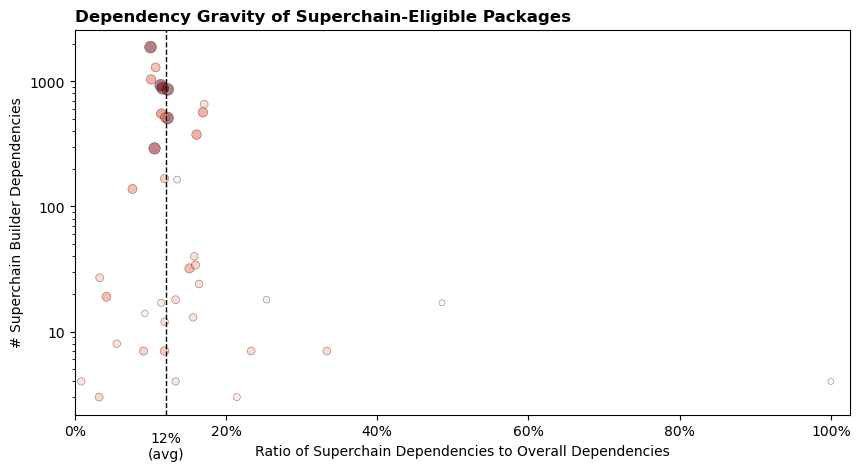

In [311]:
_gravity_cols = ['project_name', 'op_reward', 'superchain_ratio', 'superchain_dependent_repos', 'all_dependent_repos']
_df_gravity = df_project_metrics_pivoted[df_project_metrics_pivoted['is_eligible_package']][_gravity_cols]
_weighted_avg = np.average(_df_gravity['superchain_ratio'], weights=_df_gravity['superchain_dependent_repos'])

fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(
    data=_df_gravity,
    x='superchain_ratio',
    y='superchain_dependent_repos',
    size='op_reward',
    norm=LogNorm(), 
    hue='op_reward',
    palette='Reds',
    alpha=0.5,
    edgecolor='black',
    legend=False,
    ax=ax
)
ax.xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))
ax.set_xlim(0, 1.025)

ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.set_yscale('log')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{y:.0f}'))
ax.axvline(_weighted_avg, color='black', linestyle='--', linewidth=1)

# optional: annotate the line with its value
ax.text(_weighted_avg, ax.get_ylim()[0], f'\n{_weighted_avg:.0%}\n(avg)', rotation=0, va='top', ha='center')
ax.set_ylabel('# Superchain Builder Dependencies')
ax.set_xlabel('Ratio of Superchain Dependencies to Overall Dependencies')
ax.set_title("Dependency Gravity of Superchain-Eligible Packages", loc='left', weight='bold')

In [305]:
print(
    pd.concat([
        _df_gravity.sort_values(by='superchain_dependent_repos').tail(2),
        _df_gravity.sort_values(by='superchain_ratio').tail(2),
        _df_gravity.sort_values(by='superchain_ratio').head(2),   
    ])
    .sort_values(by='superchain_ratio', ascending=False)
    [['project_name', 'superchain_dependent_repos', 'all_dependent_repos', 'superchain_ratio']]
    .to_markdown(index=False, tablefmt='github')
)

| project_name       |   superchain_dependent_repos |   all_dependent_repos |   superchain_ratio |
|--------------------|------------------------------|-----------------------|--------------------|
| viem-tracer        |                            4 |                     4 |         1          |
| Aragon OSx         |                           17 |                    35 |         0.485714   |
| noble cryptography |                         1292 |                 12078 |         0.106971   |
| Ethers.js          |                         1876 |                 18725 |         0.100187   |
| Revm               |                            3 |                    93 |         0.0322581  |
| go-libp2p          |                            4 |                   463 |         0.00863931 |


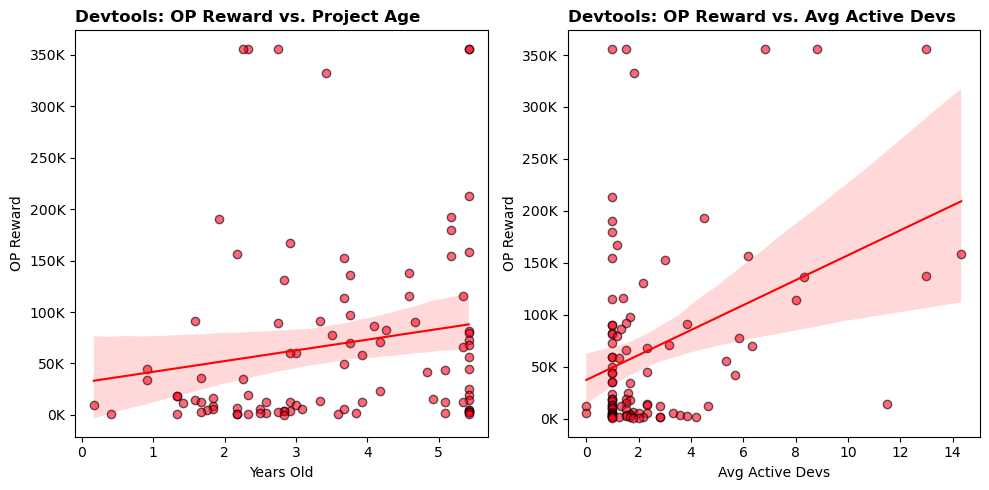

In [326]:
k_formatter = mticker.FuncFormatter(lambda y, _: f"{int(y/1000)}K")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
_df_team = df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]

# ─── LEFT PANE: devtools age vs. OP reward ───────────────────────────────
sns.regplot(
    data=_df_team,
    x='years_old',
    y='op_reward',
    scatter_kws={'alpha': 0.6, 'edgecolor': 'black', 'color': '#ff0420'},
    line_kws={'color': 'red', 'lw': 1.5},
    ax=axes[0]
)
axes[0].set_title('Devtools: OP Reward vs. Project Age', loc='left', weight='bold')
axes[0].set_xlabel('Years Old')
axes[0].set_ylabel('OP Reward')
axes[0].yaxis.set_major_formatter(k_formatter)

# ─── RIGHT PANE: avg active devs vs. OP reward ───────────────────────────
sns.regplot(
    data=_df_team,
    x='avg_active_devs',
    y='op_reward',
    scatter_kws={'alpha': 0.6, 'edgecolor': 'black', 'color': '#ff0420'},
    line_kws={'color': 'red', 'lw': 1.5},
    ax=axes[1]
)
axes[1].set_title('Devtools: OP Reward vs. Avg Active Devs', loc='left', weight='bold')
axes[1].set_xlabel('Avg Active Devs')
axes[1].set_ylabel('OP Reward')
axes[1].yaxis.set_major_formatter(k_formatter)

plt.tight_layout()
plt.show()

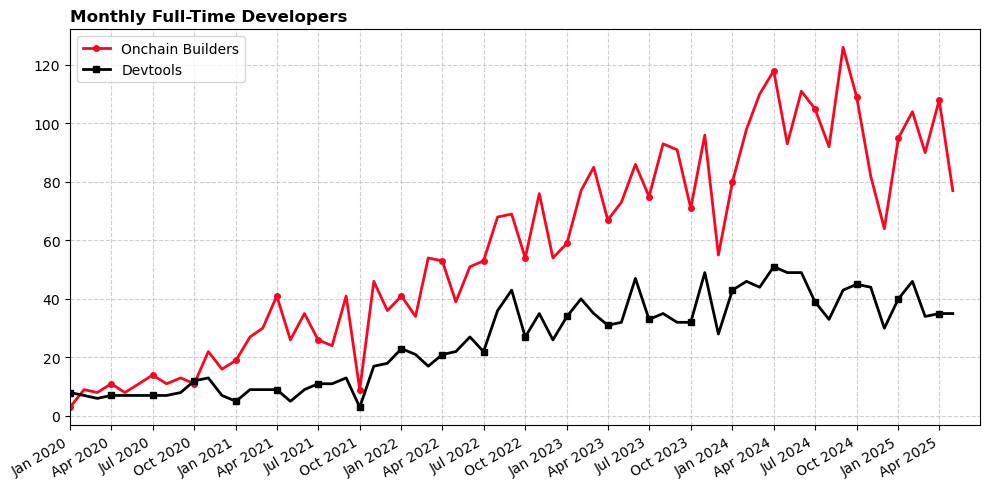

In [389]:
df_downstream_devs['sample_date'] = pd.to_datetime(df_downstream_devs['sample_date'])
df_devtool_metrics['sample_date'] = pd.to_datetime(df_devtool_metrics['sample_date'])

_downstream = (
    df_downstream_devs
    .query(f"metric == 'GITHUB_full_time_developers_monthly' & sample_date < '{SAMPLE_END_DATE}'")
    .groupby('sample_date')['amount']
    .sum()
)
_devtool = (
    df_devtool_metrics
    .query(f"metric == 'GITHUB_full_time_developers_monthly' & sample_date < '{SAMPLE_END_DATE}'")
    .groupby('sample_date')['amount']
    .sum()
)

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(_downstream.index, _downstream.values,
        label='Onchain Builders',
        color='#ff0420', linewidth=2, marker='o', markersize=4, markevery=3)
ax.plot(_devtool.index, _devtool.values,
        label='Devtools',
        color='black', linewidth=2, marker='s', markersize=4, markevery=3)

# Titles & labels
ax.set_title('Monthly Full-Time Developers', weight='bold', loc='left')
ax.set_xlabel('')
ax.set_ylabel('')

ax.set_xlim(
    pd.to_datetime("2020-01-01"),
    pd.to_datetime("2025-06-30")
)

# Legend
ax.legend(frameon=True, loc='upper left')

# Date formatting on x-axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
fig.autofmt_xdate(rotation=30, ha='right')

# Optional grid styling
ax.grid(which='major', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

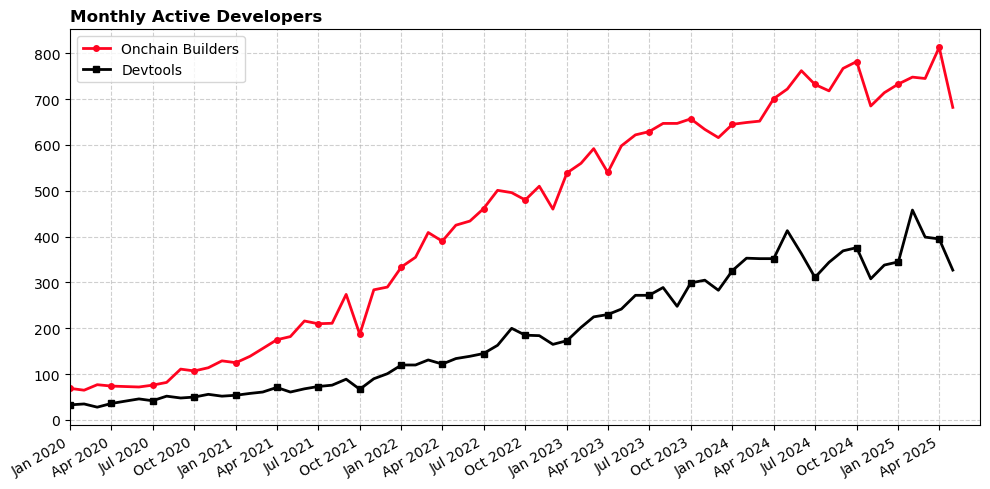

In [391]:
df_downstream_devs['sample_date'] = pd.to_datetime(df_downstream_devs['sample_date'])
df_devtool_metrics['sample_date'] = pd.to_datetime(df_devtool_metrics['sample_date'])

_downstream = (
    df_downstream_devs
    .query(f"metric == 'GITHUB_active_developers_monthly' & sample_date < '{SAMPLE_END_DATE}'")
    .groupby('sample_date')['amount']
    .sum()
)
_devtool = (
    df_devtool_metrics
    .query(f"metric == 'GITHUB_active_developers_monthly' & sample_date < '{SAMPLE_END_DATE}'")
    .groupby('sample_date')['amount']
    .sum()
)

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(_downstream.index, _downstream.values,
        label='Onchain Builders',
        color='#ff0420', linewidth=2, marker='o', markersize=4, markevery=3)
ax.plot(_devtool.index, _devtool.values,
        label='Devtools',
        color='black', linewidth=2, marker='s', markersize=4, markevery=3)

# Titles & labels
ax.set_title('Monthly Active Developers', weight='bold', loc='left')
ax.set_xlabel('')
ax.set_ylabel('')

ax.set_xlim(
    pd.to_datetime("2020-01-01"),
    pd.to_datetime("2025-06-30")
)

# Legend
ax.legend(frameon=True, loc='upper left')

# Date formatting on x-axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
fig.autofmt_xdate(rotation=30, ha='right')

# Optional grid styling
ax.grid(which='major', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()